In [7]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent
from functools import partial
import os
import torch

In [ ]:
file = np.load('raw_data/The Eiffel Tower.npz', encoding='latin1', allow_pickle=True)

In [121]:
def render_drawing(drawing_data, class_name, ax=None, is_reversed=True):
    if not is_reversed:
        drawing_data = np.flip(drawing_data, axis=0)
        
    abs_data = np.cumsum(drawing_data, axis=0)
    if drawing_data.shape[1] == 3:
        start_mask = drawing_data[:, 2] == 1
        start_indices = np.arange(len(drawing_data))[start_mask]
        start_indices = np.append(start_indices, len(drawing_data))
    else:
        start_indices = [0, len(drawing_data)]
    
    if ax == None:
        plt.title('Sketch Drawing of ' + class_name)
        ax = plt
        
    for idx in range(1, len(start_indices)):
        start = start_indices[idx-1]
        end = start_indices[idx]
        ax.plot(abs_data[start:end, 0], abs_data[start:end, 1], c = 'blue')
        
def render_strokes(file_idx, class_name, split):
    class_path = os.path.join(os.getcwd(), "data_strokes")
    class_path = os.path.join(class_path, split)
    class_path = os.path.join(class_path, class_name)
    strokes = [os.path.join(class_path, stroke) for stroke \
                            in os.listdir(class_path) if str(file_idx) + '-' in stroke]
    n_strokes = len(strokes)
    width = 20.0
    height = width / float(n_strokes)
    fig, ax = plt.subplots(1, n_strokes, figsize=(width, height))
    for idx, stroke in enumerate(strokes):
        drawing = torch.load(stroke)
        render_drawing(drawing, class_name, ax[idx])
    
def normalize_drawing(drawing_data, is_reversed=True):
    if not is_reversed:
        drawing_data = np.flip(drawing_data, axis=0)
    
    key_pts = drawing_data[:, :2]
    abs_pts = np.cumsum(key_pts, axis=0)
    min_bounds = np.min(abs_pts, axis=0)
    max_bounds = np.max(abs_pts, axis=0)
    full_sz = (max_bounds - min_bounds) + np.finfo(np.float32).eps
    
    normal_pts = ((abs_pts - min_bounds) / full_sz) - .5
    pt_diffs = np.diff(normal_pts, axis=0)
    starting_pt = np.expand_dims(normal_pts[0], axis=0)
    start_stroke = np.expand_dims(drawing_data[:, 2], axis=1)
    
    all_pts = np.concatenate((starting_pt, pt_diffs), axis=0)
    full_drawing = np.concatenate((all_pts, start_stroke), axis=1)
    
    return full_drawing

In [8]:
def create_directory(dir_name):
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
        
def create_directories(dir_name, split_list=['train', 'valid', 'test']):
    create_directory(dir_name)
    for split in split_list:
        create_directory(os.path.join(dir_name, split))

def get_class_list():
    file_list = os.listdir(os.path.join(os.getcwd(), "raw_data"))
    class_list = [filename[:-4] for filename in file_list]
    
    return class_list

def write_full_samples(file_data, write_dir, split, class_name, n_samples):
    split_dir = os.path.join(write_dir, split)
    class_dir = os.path.join(split_dir, class_name)
    create_directory(class_dir)
    
    random_set = np.random.permutation(len(file_data))[:n_samples]
    subset_data = file_data[random_set]
    
    for idx, drawing in enumerate(subset_data):
        normal_drawing = normalize_drawing(drawing, is_reversed=False)
        filename = os.path.join(class_dir, str(idx) + ".pt")
        torch.save(torch.tensor(normal_drawing), filename)


def full_data_constructor(n_samples = [1000, 100, 100]):
    class_list = get_class_list()
    
    write_dir = os.path.join(os.getcwd(), "data_full")
    split_list=['train', 'valid', 'test'] 
    create_directories(write_dir, split_list)
    
    read_dir = os.path.join(os.getcwd(), "raw_data")
    for class_name in class_list:
        class_file = class_name + ".npz"
        filename = os.path.join(read_dir, class_file)

        file_data = np.load(filename, encoding='latin1', allow_pickle=True)

        for idx, split in enumerate(split_list):
            split_data = file_data[split]
            n_split = n_samples[idx]
            write_full_samples(split_data, write_dir, split, class_name, n_split)

In [79]:
def add_strokes(drawing, class_dir, file_idx):
    stroke_mask = drawing[:, 2] == 1
    start_indices = np.arange(len(stroke_mask))[stroke_mask]
    start_indices = np.append(start_indices, len(stroke_mask))
    
    stroke_idx = 0
    for pt_idx in range(1, len(start_indices)):
        start = start_indices[pt_idx-1]
        end = start_indices[pt_idx]
        center_stroke = drawing[start:end, :2]
        center_stroke[0][0] = 0.0
        center_stroke[0][1] = 0.0
        center_stroke = center_stroke.clone().detach()
        filename = os.path.join(class_dir, str(file_idx) + '-' + str(stroke_idx) + '.pt')
        torch.save(torch.tensor(center_stroke), filename)
        stroke_idx += 1
        
def stroke_data_constructor():
    class_list = get_class_list()
    
    write_dir = os.path.join(os.getcwd(), "data_strokes")
    split_list=["train", "valid", "test"]
    create_directories(write_dir, split_list)
    
    read_dir = os.path.join(os.getcwd(), "data_full")
    for split in split_list:
        split_read= os.path.join(read_dir, split)
        split_write = os.path.join(write_dir, split)
        for class_name in class_list:
            class_read = os.path.join(split_read, class_name)
            class_write = os.path.join(split_write, class_name)
            create_directory(class_write)
            all_files = [os.path.join(class_read, file) for file in os.listdir(class_read) if file.endswith(".pt")]
            for file_idx, file in enumerate(all_files):
                drawing = torch.load(file)
                add_strokes(drawing, class_write, file_idx)

In [10]:
full_data_constructor()

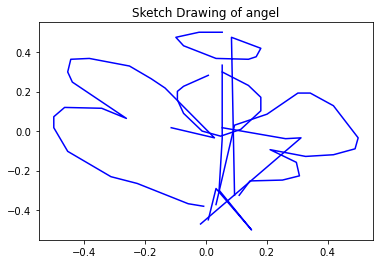

In [128]:
drawing = torch.load('data_full/train/angel/6.pt')
render_drawing(drawing, 'angel')

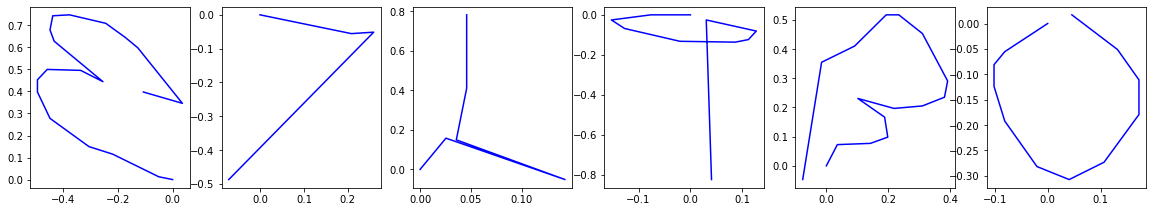

In [129]:
file_idx = 6
class_name = 'angel'
split = 'train'
render_strokes(file_idx, class_name, split)

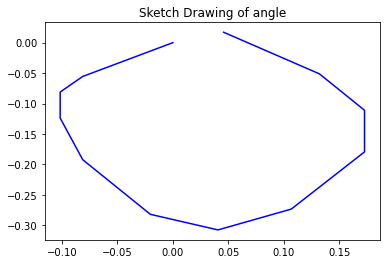

In [139]:
idx = 6
sub_idx = 5
a = torch.load('data_strokes/train/angel/' + str(idx) + '-' + str(sub_idx) + '.pt')
render_drawing(a, 'angle')

In [80]:
stroke_data_constructor()

<ipython-input-79-671aee120b3f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.save(torch.tensor(center_stroke), filename)
